In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon, image, init, nd
from mxnet.gluon import model_zoo, nn
import time

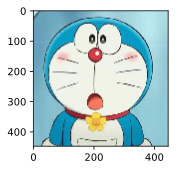

In [86]:
d2l.set_figsize()
content_img = image.imread('../img/test (1).png')
d2l.plt.imshow(content_img.asnumpy());

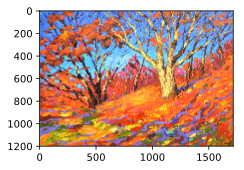

In [87]:
style_img = image.imread('../img/autumn_oak.jpg')
d2l.plt.imshow(style_img.asnumpy());

In [88]:
rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

# 预处理函数，先标准化后转化成卷积神经能够接受的格式
def preprocess(img, image_shape):
    img = image.imresize(img, *image_shape)
    img = (img.astype('float32') / 255 - rgb_mean) / rgb_std
    return img.transpose((2, 0, 1)).expand_dims(axis=0)

# 后处理函数，将输出图像的像素值还原回标准化之前
def postprocess(img):
    img = img[0].as_in_context(rgb_std.context)
    return (img.transpose((1, 2, 0)) * rgb_std + rgb_mean).clip(0, 1)

In [89]:
pretrained_net = model_zoo.vision.vgg19(pretrained=True)

In [90]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [91]:
net = nn.Sequential()
for i in range(max(content_layers + style_layers) + 1):
    net.add(pretrained_net.features[i])

In [92]:
# 通过逐层计算保留内容层和样式层的输出
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [93]:
# get_contents函数对内容图像抽取内容特征
def get_contents(image_shape, ctx):
    content_X = preprocess(content_img, image_shape).copyto(ctx)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

# get_styles函数则对样式图像抽取样式特征
def get_styles(image_shape, ctx):
    style_X = preprocess(style_img, image_shape).copyto(ctx)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

In [94]:
# 内容损失
def content_loss(Y_hat, Y):
    return (Y_hat - Y).square().mean()

In [95]:
# 将格拉姆矩阵除以了矩阵中元素的个数，即 chw 。
def gram(X):
    num_channels, n = X.shape[1], X.size // X.shape[1]
    X = X.reshape((num_channels, n))
    return nd.dot(X, X.T) / (num_channels * n)
# 样式损失
def style_loss(Y_hat, gram_Y):
    return (gram(Y_hat) - gram_Y).square().mean()

In [96]:
# 总变差损失
def tv_loss(Y_hat):
    return 0.5 * ((Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).abs().mean() +
                  (Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).abs().mean())

In [97]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、样式损失和总变差损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = nd.add_n(*styles_l) + nd.add_n(*contents_l) + tv_l
    return contents_l, styles_l, tv_l, l

In [98]:
class GeneratedImage(nn.Block):
    def __init__(self, img_shape, **kwargs):
        super(GeneratedImage, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=img_shape)

    def forward(self):
        return self.weight.data()

In [99]:
# 该函数创建了合成图像的模型实例，并将其初始化为图像X
def get_inits(X, ctx, lr, styles_Y):
    gen_img = GeneratedImage(X.shape)
    gen_img.initialize(init.Constant(X), ctx=ctx, force_reinit=True)
    trainer = gluon.Trainer(gen_img.collect_params(), 'adam',
                            {'learning_rate': lr})
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [100]:
def train(X, contents_Y, styles_Y, ctx, lr, max_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, ctx, lr, styles_Y)
    for i in range(max_epochs):
        start = time.time()
        with autograd.record():
            contents_Y_hat, styles_Y_hat = extract_features(
                X, content_layers, style_layers)
            contents_l, styles_l, tv_l, l = compute_loss(
                X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step(1)
        # 防止内存占用过高
        nd.waitall()
        if i % 50 == 0 and i != 0:
            print('epoch %3d, content loss %.2f, style loss %.2f, '
                  'TV loss %.2f, %.2f sec'
                  % (i, nd.add_n(*contents_l).asscalar(),
                     nd.add_n(*styles_l).asscalar(), tv_l.asscalar(),
                     time.time() - start))
        if i % lr_decay_epoch == 0 and i != 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.1)
            print('change lr to %.1e' % trainer.learning_rate)
    return X

In [101]:
ctx, image_shape = d2l.try_gpu(), (225, 150)
net.collect_params().reset_ctx(ctx)
content_X, contents_Y = get_contents(image_shape, ctx)
_, styles_Y = get_styles(image_shape, ctx)
output = train(content_X, contents_Y, styles_Y, ctx, 0.01, 500, 200)

epoch  50, content loss 24.35, style loss 65.36, TV loss 2.80, 0.03 sec
epoch 100, content loss 22.89, style loss 33.43, TV loss 3.44, 0.04 sec
epoch 150, content loss 20.61, style loss 24.99, TV loss 3.72, 0.04 sec
epoch 200, content loss 19.02, style loss 20.57, TV loss 3.92, 0.04 sec
change lr to 1.0e-03
epoch 250, content loss 18.85, style loss 20.16, TV loss 3.93, 0.04 sec
epoch 300, content loss 18.71, style loss 19.80, TV loss 3.95, 0.03 sec
epoch 350, content loss 18.58, style loss 19.44, TV loss 3.97, 0.04 sec
epoch 400, content loss 18.44, style loss 19.07, TV loss 3.99, 0.04 sec
change lr to 1.0e-04
epoch 450, content loss 18.42, style loss 19.03, TV loss 3.99, 0.04 sec


In [102]:
d2l.plt.imsave('../img/neural-style-1.png', postprocess(output).asnumpy())

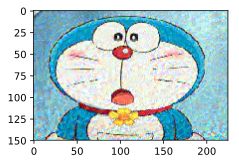

In [103]:
d2l.plt.imshow(postprocess(output).asnumpy())

In [84]:
image_shape = (450, 300)
_, content_Y = get_contents(image_shape, ctx)
_, style_Y = get_styles(image_shape, ctx)
X = preprocess(postprocess(output) * 255, image_shape)
output = train(X, content_Y, style_Y, ctx, 0.01, 300, 100)
d2l.plt.imsave('../img/neural-style-2.png', postprocess(output).asnumpy())

epoch  50, content loss 1.11, style loss 1.64, TV loss 0.76, 0.10 sec
epoch 100, content loss 0.89, style loss 1.37, TV loss 0.66, 0.10 sec
change lr to 1.0e-03
epoch 150, content loss 0.87, style loss 1.35, TV loss 0.65, 0.10 sec
epoch 200, content loss 0.86, style loss 1.33, TV loss 0.64, 0.10 sec
change lr to 1.0e-04
epoch 250, content loss 0.86, style loss 1.33, TV loss 0.64, 0.10 sec


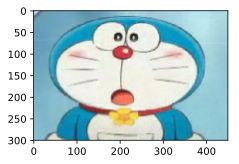

In [85]:
d2l.plt.imshow(postprocess(output).asnumpy())

In [38]:
pretrained_net 

VGG(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Activation(relu)
    (2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Activation(relu)
    (4): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (5): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Activation(relu)
    (7): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Activation(relu)
    (9): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (10): Conv2D(128 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Activation(relu)
    (12): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Activation(relu)
    (14): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

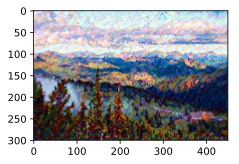

In [39]:
d2l.plt.imshow(postprocess(output).asnumpy());